#### <i> PODSUMOWANIE: 
    Zadanie 1 i 2 wydają się robić to co trzeba.
    W zadaniu 3 brakuje opcji: "Zdalne kanały komunikacji pomiędzy zadaniami na różnych workerach."

### 1. Program w którym działają trzy zadania (w tym samym procesie), z których każde wypisuje w pętli kilka razy jedną liczbę (pierwsze "1", drugie "2", trzecie "3"). 

In [1]:
function f1(n :: Int64)
  @sync begin
    last = 1
    for i in 1:3
      @async begin
          while(n > 0)
            if(last == i)
              print(i, " ")
              last = last % 3 + 1
              n -= 1
              yield()
            else
              yield()
            end
          end
      end
    end
  end
end

f1 (generic function with 1 method)

In [2]:
f1(100)

1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 

### 2. Producenci i konsumenci.

In [3]:
path="/Users/jzawalska/Desktop/julia-lab"
extension="ipynb"
size=20

20

In [9]:
function producer(c::Channel)
        for (root, dirs, files) in walkdir(path)
        for file in files
            if(extension!="" && split(file, ".")[end] != extension)
                continue
            end
            put!(c,joinpath(root, file))
            yield()
        end
        
    end
      close(c)   
end

producer (generic function with 1 method)

In [10]:
function consument(c::Channel)
    local_sum=0
    for file in c
        println("received: ", file)
        local_sum+=countlines(file)
        yield()
    end
    return local_sum
end

consument (generic function with 1 method)

In [11]:
@sync begin
    c=Channel{String}(32)
    sums=SharedArray{Int64}(size)
    @async producer(c)
    @sync for i=1:size
        @async sums[i] = consument(c)
    end
    return sum(sums)
end

received: /Users/jzawalska/Desktop/julia-lab/lab03/LAB3_JZawalska.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab04/LAB4_JZawalska.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab05/LAB5_JZawalska.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab06/LAB6_JZawalska.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab03/.ipynb_checkpoints/LAB3_JZawalska-checkpoint.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab04/.ipynb_checkpoints/LAB4_JZawalska-checkpoint.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab05/.ipynb_checkpoints/LAB5_JZawalska-checkpoint.ipynb
received: /Users/jzawalska/Desktop/julia-lab/lab06/.ipynb_checkpoints/LAB6_JZawalska-checkpoint.ipynb


5880

#### - powyżej zwrócona całkowita liczba linii we wszystkich plikach

### 3. Program obliczający zbiór Julii.

 #### a) Wykorzystując parallel for

  3.414043 seconds (31.23 M allocations: 1.249 GiB, 7.71% gc time)


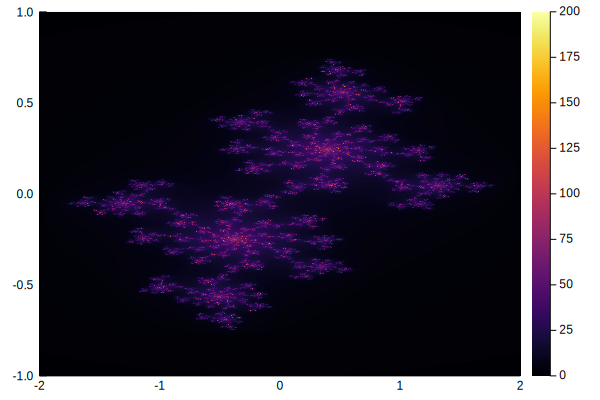

In [7]:
using Plots
Plots.gr()

@everywhere function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    maxiter
end

function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
    for x=width_start:width_end
        @sync @parallel for y=1:height
            z = xrange[x] + 1im*yrange[y]
            julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
        end
    end
end

function calc_julia_main(h,w)
   xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
   julia_set = SharedArray{Int64}(w, h)
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)
   generate_plot = Plots.heatmap(xrange, yrange, julia_set)
   png("julia_3a")
   plot(generate_plot)
end


calc_julia_main(2000,2000)

#### b) Wykorzystując pmap

-1.8019009504752377-0.8999499749874937
  2.709907 seconds (12.39 M allocations: 691.857 MiB, 4.35% gc time)


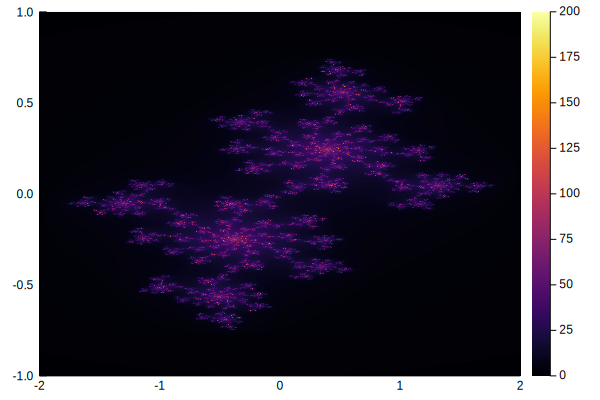

In [8]:
using Plots
Plots.gr()

function generate_julia(z; c=2, maxiter=200)
    for i=1:maxiter
        if abs(z) > 2
            return i-1
        end
        z = z^2 + c
    end
    return maxiter
end

function call_generate(julia_set, x, xrange, yrange, height, maxiter)
  for y=1:height
    z = xrange[x] + 1im*yrange[y]
    julia_set[x, y] = generate_julia(z, c=-0.70176-0.3842im, maxiter=maxiter)
  end
end

function calc_julia!(julia_set, xrange, yrange; maxiter=200, height=400, width_start=1, width_end=400)
   x=collect(width_start:width_end)
   pmap(l->call_generate(julia_set, l, xrange, yrange, height, maxiter), x)
end


function calc_julia_main(h,w)
   xmin, xmax = -2,2
   ymin, ymax = -1,1
   xrange = linspace(xmin, xmax, w)
   yrange = linspace(ymin, ymax, h)
	println(xrange[100],yrange[101])
   julia_set = SharedArray{Int64}(w, h)
   @time calc_julia!(julia_set, xrange, yrange, height=h, width_end=w)

   generate_plot = Plots.heatmap(xrange, yrange, julia_set)
   png("julia_3b")
   plot(generate_plot)
end

calc_julia_main(2000,2000)